# Shannon_Demon
Backtests various versions of Shannns Demon strategy. demon strategy is to rebalance frequently between cash and a stock.
This program backtests many versions of the strategy.

Started 04/20/23
Last edit 04/24/23

User controls
1. Stock ticker list. Shannon_Demon will invest these stocks. Cash is total cash for ALL the stocks, plus cash acct. 
2. Invest freq. (Daily. Weekly, Monthly, Quarterly, Annual). Maybe set as # trading days. 
3. Plot results.
4. Calculate ARR, max. drawdown, max. neg duration, and Sharpe ratio for this long-only strategy.

Files
1. price history - permanent file. It saves the EOD prices for each ticker and adds to the file. When tickers are chenged, SD checks this file and gets only the prices missing from the price_history file.
2. run results - SD records actual run results for each scenario in a separate file. 
3. run_log - a log of all runs, with file ID, run date, tickers, cash, and stats for the run.

Complete Process
1. Read specs for this run.
2. Check price_history file to see which prices are needed
3. Get those prices from DARqube.
4. Set up the results dataframe.
5. Run the backtest.
6. Calculate the stats for the run.
7. Update the run_log.
8. Plot the results.

Development Steps
1. Write backtester.
  a. Write pricegrabber.
  b. Write backtester.
  c. Write performance analyzer.
  d. Save results.
2. Write run_logger.
3. Write DataSaver.



# TODO
Developer ToDo list 04/21/23.
1. Write fct Rebal_Dates, which finds EOW, EOM, EOQ and EOY trade dates.



In [1]:
# **********
#
#Shannon_Demon - created 04/21/23
#    Goal - Test versions of shannon's Demon and compare performance stats.
#     Steps
#          1. Initialize libraries, constants, etc.
#          2. Get prices for selected tickers from DARqube.
#          3. Calculate turning  ponts price_change delta for date D from date D - MAX_SPIKE DAYS
#
# **********

# **********
#
# User sets constants
#
# **********

# Set DAR_key
DAR_key = '90180f15ecc74513a01ca017eca2bb4f'
# Set TIKCERS = ('XXX', 'YYY')
TICKERS = ('DDOG', 'SNOW', 'CRWD') #, 'FSLY', 'OKTA', 'NWBO', 'SANA', 'ONCS', 'BBAI')

# Set minimum pivot point size as a percent. Adjust this to produce a chart where each zigzag takes 5-25 trading days.
PIVOT_POINT_PCT = .05

# Set DAYS_BACK as an integer number of days back from yesterday.
DAYS_BACK = 90 # approx. 1 year. Note DAYS_BACK uses calendar days, not trading days. 

# **********
#
# Import LIbraries
#
# **********

import csv
import copy
import json
import matplotlib.pyplot as plt
from   matplotlib.pyplot import plot, scatter

import datetime as dt
import numpy as np
import os
import pandas as pd
import requests   # for http requests
import scipy
from   scipy import stats
from   scipy.stats import norm
import stock_indicators
from   stock_indicators import indicators, EndType
from   stock_indicators.indicators.common.enums import EndType

import time
import yfinance as yf


In [2]:
# **********
#
#ZigZagPlotter - functions that cal the ZigZag pivot points.
#
# **********

def pct_change(X):
    data_pct_change = diff(X, 1, None) / shift(X,1, None) 
    return data_pct_change

def shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def diff(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[num:] - arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[:num] - arr[-num:]
    else:
        result[:] = arr
    return result

def calczigzag(X, pc, include_first):

    data_pct_change = pct_change(X)
    pct_change_mask = np.sign(data_pct_change)
    pct_change_mask_abs_diff = np.abs(diff(pct_change_mask,1,np.nan))
    split_mask = np.where(pct_change_mask_abs_diff == 2)[0] - 1
    
    data_split_pct_change = pct_change(X[split_mask])

    data_split_pct_change_filtered_indices = np.where(np.abs(data_split_pct_change) > pc)
    data_split_pct_change_filtered = data_split_pct_change[data_split_pct_change_filtered_indices]
    pivot_indices = split_mask[data_split_pct_change_filtered_indices]
    pivot_indices_filtered = pivot_indices[diff(np.sign(data_split_pct_change_filtered),-1,None)!= 0]
    if include_first:
        pivot_indices_filtered = np.concatenate(([0],pivot_indices_filtered))
        
    return pivot_indices_filtered

def zigzag(X, pc, include_first = True):
    '''
    X: numpy.ndarray/list/pandas.core.series.Series
        Data
    pc: float
        Precision level
    include_first: bool
        Boolean indicating whether to include the first observation as a pivot point
    '''

    if type(X) is np.ndarray:
        pivot_indices = calczigzag(X, pc, include_first)
        return pivot_indices

    elif type(X) is pd.Series:
        X_np = X.values 
        X_index = X.index
        pivot_indices = calczigzag(X_np, pc, include_first)
        return X_index[pivot_indices]

    elif type(X) is list:
        X_np = np.array(X)
        pivot_indices = calczigzag(X_np, pc, include_first)
        return pivot_indices
    
    else:
        raise ValueError("X should be pd.series, np.array or list")

print('Loaded the zigzag functions.')


Loaded the zigzag functions.


In [ ]:
# **********
#
# Demon Functions
# GetRebalDates
# GetStockPrices
# Backtester - runs backtests with various configs.It calls PortTrader to execute all actual trades.
# PortTrader - Recommends trades according to Demon rules and logs results for tracking. Calculates performance.
# DemonPlot - plots performance for the selected run.
# DemonLogger - logs all the results.
#
# **********

# **********
#
# GetStockPrices
# 1. Check demon_stock_prices to see if new tickers or new date range. If so, get needed stock prices from Darqube.
# 2. write the updated file demon_stock_prices.csv. Note this is a persistent data file. 
#
# **********
def GetStockPrices(start_date, end_date, tickers):
    pass
    return demon_stock_prices

# **********
#
# GetRebalDates
# 1. Read rebal_dates.csv, which contains the complete set of trade dates and rebal dates so far. 
# 2. Check backtest date range to see if more trade dates needed. If so, call Darqube to fill the date range.
# 2. If rebal_dates.csv does not exist, thenget dates starting 01/01/2000 and calculate all rebal dates.
# 3. Rebal dates are EOW, EOM, EOQ, and EOY. rebal_dates_df has corresponding cols. It is a sparse df.
#
# **********
def GetRebalDates(start_date, end_date, rebal_freq):
    pass
    return rebal_dates

# **********
#
# RebalDemon
# 1. Set up portfolio df.
# 2. For each rebal date, get prices and rebalance each stock holding. 
# 3. Read rebal_date.csv, which contains the complete set of trade dates and rebal dates so far. 
# 2. Check backtest date range to see if more trade dates needed. If so, call Darqube to fill the date range.
# 2. If rebal_dates.csv does not exist, thenget dates starting 01/01/2000 and calculate all rebal dates.
# 3. Rebal dates are EOW, EOM, EOQ, and EOY. rebal_dates_df has corresponding cols. It is a sparse df.
#
# **********

def RebalDemon(rebal_dates, rebal_freq, ticker_prices, start_date, end_date, tickers, start_cash):
    #TODO - Consider
    # Note both rebal_dates and ticker_prices MUSt use the price date as the index. 
    # Select ticker prices that match the rebal dates. Note this assumes you buy at the EOD price, not next morning!
    # Can code the buy either way, but muist konw the BOD price for the next day.
    run_report = ticker_prices.copy() #note ticker prices
    run_report['rebal_dates'] = rebal_dates[rebal_freq] # this col is True where date is rebal (EOW, EOM, EOQ, EOY).
    run_report = run_report[run_report['rebal_dates'] == True].copy()
        
    # Initialize column names for run_report df.
    report_cols = ['Cash']
    for tick in tickers:
        tick_shares = tick + '_Shares'
        tick_value  = tick + '_Value'
        tick_price  = tick + '_Price'
        tick_price_change = tick + '_Price_Chg'
        tick_cash   = tick + '_Cash'
        tick_cols = [tick_value, tick_price, tick_price_change, tick_cash]
        report_cols.extend(tick_cols)
        
    tick_cols = pd.DataFrame(index = run_report[rebal_dates], columns = report_cols, dtype = 'float')
    run_report.merge(run_report, tick_cols, copy = True)

    # Initialize first row with start_cash total and ticker_start_cash
    run_report.loc[start_date, 'Cash'] = start_cash
    cash_per_tick = start_cash / len(tickers) / 2.0
    
    for tick in tickers:
        tick_shares = tick + '_Shares'
        tick_value  = tick + '_Value'
        tick_price  = tick + '_Price'
        tick_price_change = tick + '_Price_Chg'
        tick_cash   = tick + '_Cash'
  
        run_report.loc[start_date, [tick_cash]]  = cash_per_tick
        run_report.loc[start_date, [tick_value]] = cash_per_tick
        run_report.loc[start_date, [tick_shares]]= cash_per_tick / run_report.loc[start_date, tick_price]]
        
        # Do vector ops to run the backtest.
        run_report['prev_price'] = run_report[tick_price].shift(periods = 1)
        run_report[tick_price_change] = run_report[tick_price] - run_report['prev_price']
        run_report['tick_rebal_val'] = run_report[tick_price_change] / run_report['prev_price']
        run_report[tick_cash]  = run_report[tick_cash] + run_report['tick_rebal_val']
        run_report[tick_value] = run_report[tick_value] - run_report['tick_rebal_val']
        run_report[tick_shares]= run_report[tick_shares] - run_report['tick_rebal_val'] / run_report[tick_price]
        
    return run_report
        
# **********
#
# Scorekeeper generates performance stats for each run_report.
# 1. Set up run_results df.
# 2. Calculate each metric: Sharp Ratio, max drawdown (google MDD), MAR (=CAGR / MDD), another risk measurement.. 
#      Others? Upcapture, down capture (daily?), CAGR, tot. return
# 4. Pick a comparison index for Sharpe Ratio.
# 5. To calc MDD< use pd.expanding.
# **********

def Scorekeeper(run_report, index):
    
    

    

TODAY =  2023-04-17 17:35:30.946898
for  DDOG


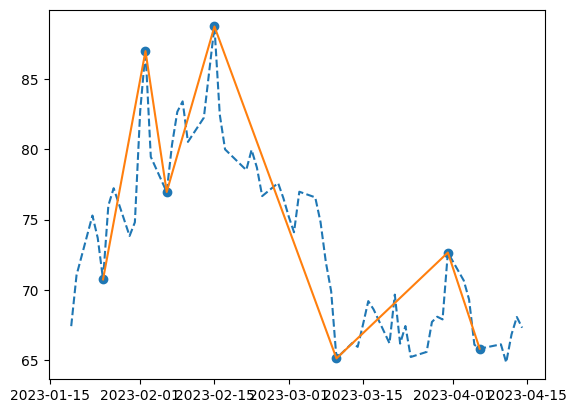

DDOG  plot done.


for  SNOW


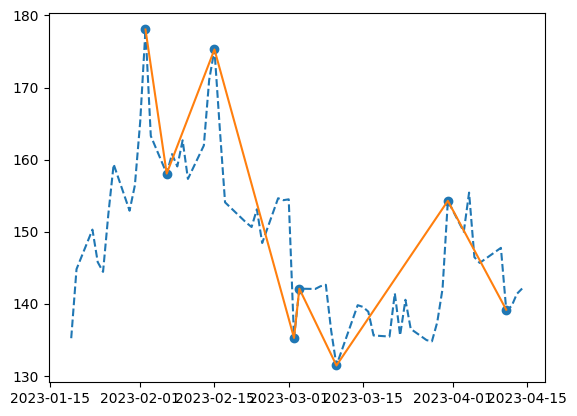

SNOW  plot done.


for  CRWD


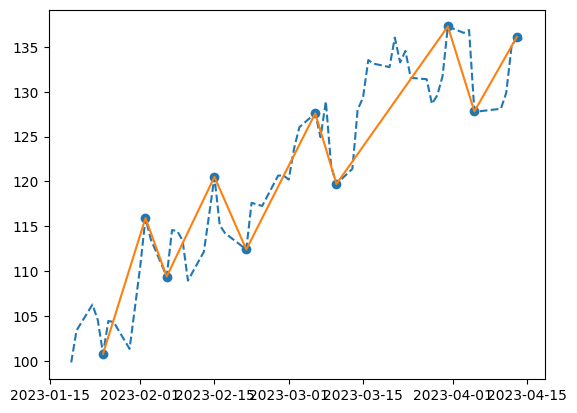

CRWD  plot done.


thats all folks


In [4]:
# **********
#
# Main Program
#1. Read specs for this run.
#2. Check price_history file to see which prices are needed
#3. Get those prices from DARqube.
#4. Set up the results dataframe.
#5. Run the backtester.
#6. Calculate the stats for the run.
#7. Update the run_log.
#8. Plot the results.
#
# **********

results_cols = ['Cash', 'Ticker_01_price', 'Ticker_01_shares', 'Ticker_01_vlaue', 'rebal'] # for each ticker
run_log_cols = ['run_file_ID', 'run_date', 'start_date', 'end_date', 'rebal_freq', 'start_cash', \
                'tickers', 'periods', 'min_cash', 'max_drawdown', 'max_down_duration', 'Sharpe_ratio', \
                'ARR', 'cum_return']

ticker_prices = pd.DataFrame(columns = ['time', 'Ticker', 'price'])

if run_type == 'backtest':
    # every backtest is new, so initialize backtest.
    # Get prices for selected tickers and date range.
    # Get EOX dates based on backtest trade freq.
    # Execute backtest with vector ops over date range, trade_freq, and tickers.
    # Calculate performance stats.
    # Log run in run_log. Log stats in run_log.
    # Save backtest file and updated run_log.
    # print charts of ticker values and cash on hand.
    
if run_type == 'port_trade':
    # If port does not show up in run_log, then initialize this port in the run log and initialize the port_trade file.
    # read port_trade file to set up trades.
    # Check date and print recommended trades based on port_trade details
    # Calculate port performance stats and generate plots.

'
TODAY = dt.datetime.today()
print('TODAY = ', TODAY)

end_date = TODAY - dt.timedelta(days = 1)
#print('end_date = ', end_date)
end_date_str = str(int(end_date.timestamp()))
#print('end_date_str = ', end_date_str)
start_date = TODAY - dt.timedelta(days = DAYS_BACK)
start_date_str = str(int(start_date.timestamp()))
#print('start_date = ', start_date)
#print('start_date_str = ', start_date_str)
for ticker in TICKERS:
    
    ticker_df = pd.DataFrame()
    price_rqst = 'https://api.darqube.com/data-api/market_data/historical/' + ticker + '?token=' + DAR_key + \
                    '&start_date=' + start_date_str + '&end_date=' + end_date_str + '&interval=1d'
    
    #price_rqst = 'https://api.darqube.com/data-api/market_data/quote/' + ticker + '?token=' + DAR_key
    response = requests.get(price_rqst)
    price_dict = response.json()
    ticker_prices = pd.DataFrame(data = price_dict)
    ticker_prices['date'] = pd.to_datetime(ticker_prices['time'], unit = 's')
    ticker_prices.set_index('date', inplace = True)
    
    X = ticker_prices['adjusted_close']
    zz_pivots = zigzag(X,PIVOT_POINT_PCT, False)
    
    print('for ', ticker)
    plot(X, '--')
    plot(zz_pivots, X[zz_pivots])
    scatter(zz_pivots, X[zz_pivots])
    #plt.figure(figsize = (10, 4.8))
    #plt.xticks(rotation = 90)
    #display(plt.plot(x,y))
    plt.show()
    print(ticker, ' plot done.')
    print()
    print()
    
print('thats all folks')
